# 📰 Fake News Detection Using Ensemble Learning

---

| S. No |    ID No.     | Name             |
| ----: | :-----------: | :--------------- |
|    1. | 2022A7PS0003U | Yusra Hakim      |
|    2. | 2022A7PS0019U | Joseph Cijo      |
|    3. | 2022A7PS0031U | Ritvik Bhatnagar |

This Jupyter Notebook is for the project in Data Mining (CS F415) course. It contains the code used for preparing the ensemble model using the [dataset](#dataset-used) mentioned below.

### Dataset Details

**Dataset introduced in:**
V. Pawan Kumar, A. Prateek, A. Ivone and P. Radu, "WELFake: Word Embedding Over Linguistic Features for Fake News Detection," _IEEE Transactions on Computational Social Systems_, vol. 8, no. 4, pp. 881-893, 2021.
[Kaggle | WELFake Dataset](https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification)

### Setting Up an Environment for the Jupyter notebook

Firstly install Miniconda from [here](https://docs.anaconda.com/miniconda/install/).

Then open a command prompt in this directory, and run the following. This will create and activate an environment called "PROJ".

```bash
    conda create -n proj python=3.12
    conda activate proj
```

After running this, your CMD prompt should have a "`(proj)`" prefixed at the start.

Run the following command to install packages, such as [PyTorch](https://pytorch.org/get-started/locally/). This will take some time.


In [ ]:
%pip uninstall torch -y


In [ ]:
%conda install -n proj ipykernel ipywidgets --update-deps --force-reinstall
%conda install -n proj nltk
%conda install -n proj conda-forge::textblob
%pip install scikit-learn matplotlib seaborn pandas pyperclip contractions scipy numpy
%conda install -n proj conda-forge::transformers
%conda install -n proj conda-forge::lightgbm
%pip install torch --index-url https://download.pytorch.org/whl/cu128


Remember to select the PROJ environment at the bottom-right.

---

# 1. 📚 Outline

To train the model, the following steps must be followed:

<img src="assets/archdiag.png" size=64/>

The model will accept two inputs:
1. The headline of the article
2. Content of the article (Optional)

And give an output if it is fake news or factual (real) news.

---

## Imports

In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, issparse
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    confusion_matrix,
)
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob

# from transformers.models.distilbert import DistilBertTokenizer, DistilBertModel

import lightgbm as lgb

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

from IPython.display import display, HTML
import ipywidgets as widgets

import random
import re
import os

import pickle
import contractions


# 2. 📑 Dataset Tomfoolery

The dataset is a CSV file with the following columns:

- _title_: the title of the article
- _text_: the text of the article
- _label_: the label of the article (0 for fake, 1 for real)

The dataset used is the WELFake dataset [available here](https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification)

This dataset is a collection of news articles, with each article labeled as either fake or real. The dataset contains 10,000 articles, with 5,000 fake and 5,000 real articles. The articles are in English and cover a wide range of topics, including politics, sports, entertainment, and technology.

In [ ]:
df = pd.read_csv("dataset_and_corpora/WELFake_Dataset.csv", index_col=0)

df.head()


## ✂️ Splitting Dataset

The dataset is split as
-  80% → Training + Validation Set
-  20% → Testing Set

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [ ]:
print(f"Training set size: {train_df.shape}")
train_df.to_csv("dataset_and_corpora/train.csv", index=False)
train_df.head()


In [ ]:
print(f"\nTesting set size: {test_df.shape}")
test_df.to_csv("dataset_and_corpora/test.csv", index=False)
test_df.head()


## 👾 Data Preprocessing

The data is preprocessed using the following steps
1. [Text Cleaning](#text-cleaning)
   1. [Lowercasing & URL Removal](#lowercasing-url-removal)
   2. [Contractions Expansion](#contractions-expansion)
   3. [Tokenization](#tokenization)
   4. [Lemmatization](#lemmatization)
   5. [Stopword Removal](#stopword-removal)
2. [Data Augmentaiton](#data-augmentation)
   1. [Synonym Replacement](#synonym-replacement)
   2. [Random Insertion](#random-insertion)
   3. [Random Swap](#random-swap)
   4. [Random Deletion](#random-deletion)

---

### 🧹 Data Cleaning

The text in the datast has to be cleaned before it can be used for training the model. The following steps are used for cleaning the text.

[Kaggle | Getting started with Text Preprocessing](https://www.kaggle.com/code/sudalairajkumar/getting-started-with-text-preprocessing)


#### Merging Text Values

In [ ]:
def merge_title_and_text(df: pd.DataFrame) -> pd.DataFrame:
    """
    Merge the 'title' and 'text' fields into a single 'content' field.

    :param df: Input DataFrame
    :return: DataFrame with a new 'content' field
    """

    df["content"] = df["title"].fillna("") + " " + df["text"].fillna("")
    return df


#### Handling Missing Values

In [ ]:
def handle_missing_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Handle missing data in the DataFrame by removing rows with any empty, NaN values, or rows containing only whitespaces.

    :param df: DataFrame to process
    :return: DataFrame with rows containing any empty, NaN values, or whitespaces-only content removed
    """

    missing_values = df.isnull().sum()
    print("Missing values in each column:\n", missing_values)

    df = df.replace("", np.nan)

    df = df.dropna()

    return df


#### Lowercasing & URL Removal

The text is converted to lowercase and URLs are removed from the text.

In [ ]:
def lowercase_and_remove_urls(text: str) -> str:
    """
    Convert text to lowercase and remove URLs.

    :param text: Input text
    :return: Processed text with URLs removed
    """

    text = text.lower()

    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    return text


#### Contractions Expansion

Contractions are expanded to their full form. For example, "I'm" is expanded to "I am". Using the [`contractions`](https://github.com/kootenpv/contractions/tree/master) library for this purpose.

In [ ]:
def expand_contractions(text: str) -> str:
    """
    Expand contractions in the text using the `contractions` library.

    :param text: Input text
    :return: Text with contractions expanded
    """

    expanded_words = [contractions.fix(word) for word in text.split()]
    expanded_text = " ".join(expanded_words)  # type: ignore
    return expanded_text


#### Tokenization

The text is tokenized into words. This also removes punctuation and any special characters.

The [`RegexpTokenizer`](https://www.nltk.org/api/nltk.tokenize.RegexpTokenizer.html) tokenizer is used for tokenization by aplphanumeric words and to ignore all other characters.

In [ ]:
def tokenize_text(text: str) -> list:
    """
    Tokenize the input text using NLTK's RegexpTokenizer.

    :param text: Input text
    :return: List of tokens
    """

    tokenizer = RegexpTokenizer(r"\w+")
    tokens = tokenizer.tokenize(text)
    return tokens


#### Lemmatization

The words are lemmatized to their root form. This is done using the [`WordNetLemmatizer`](https://www.nltk.org/api/nltk.stem.html#nltk.stem.wordnet.WordNetLemmatizer) from the NLTK library.

In [ ]:
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("wordnet")


In [ ]:
lemmatizer = WordNetLemmatizer()


def nltkToWordnet(nltk_tag: str) -> str:
    """
    Convert NLTK POS tags to WordNet POS tags.

    :param nltk_tag: NLTK POS tag
    :return: WordNet POS tag
    """

    if nltk_tag.startswith("J"):
        return wordnet.ADJ
    elif nltk_tag.startswith("V"):
        return wordnet.VERB
    elif nltk_tag.startswith("N"):
        return wordnet.NOUN
    elif nltk_tag.startswith("R"):
        return wordnet.ADV
    else:
        return None  # type: ignore


def lemmatize_text(tokens: list) -> list:
    """
    Lemmatize the tokens using NLTK's WordNetLemmatizer.

    :param tokens: List of tokens
    :return: List of lemmatized words
    """

    pos_tags = nltk.pos_tag(tokens)
    res_words = []
    for word, tag in pos_tags:
        tag = nltkToWordnet(tag)
        if tag is None:
            res_words.append(word)
        else:
            res_words.append(lemmatizer.lemmatize(word, tag))
    return res_words


#### Stopword Removal

Stopwords are removed from the text. Stopwords are common words that do not add much meaning to the text. The [`stopwords`](https://www.nltk.org/api/nltk.corpus.reader.html#nltk.corpus.reader.wordlist.WordListCorpusReader) from the NLTK library are used for this purpose.


In [ ]:
nltk.download("words")
nltk.download("stopwords")


In [ ]:
englishWords = set(nltk.corpus.words.words())
stop_words = set(stopwords.words("english"))


def remove_stopwords(tokens: list) -> str:
    """
    Remove stop words from the list of tokens.

    :param tokens: List of tokens
    :return: List of tokens without stop words
    """

    filtered_words = [w for w in tokens if (w in englishWords and w not in stop_words)]
    filtered_text = " ".join(filtered_words)
    return filtered_text


---

#### Performing Text Cleaning

Function to perform text cleaning on the dataset.

In [ ]:
def clean_text(text: str) -> str:
    """
    Clean the input text by applying various preprocessing steps.

    :param text: Input text
    :return: Cleaned text
    """
    text = lowercase_and_remove_urls(text)
    text = expand_contractions(text)
    tokens = tokenize_text(text)
    tokens = lemmatize_text(tokens)
    text = remove_stopwords(tokens)
    return text


In [ ]:
progress = widgets.IntProgress(
    value=0, min=0, max=len(train_df), description="Cleaning:"
)


In [ ]:
display(progress)

cleaned_data = []
train_df = merge_title_and_text(train_df)
train_df = handle_missing_data(train_df)

for index, row in train_df.iterrows():
    content = row["content"] if pd.notnull(row["content"]) else ""

    cleaned_content = clean_text(content)

    cleaned_data.append({"content": cleaned_content, "label": row["label"]})

    progress.value += 1

cleaned_train_df = pd.DataFrame(cleaned_data)
cleaned_train_df = handle_missing_data(cleaned_train_df)

cleaned_train_df.head()


---

### 🥀 Data Augmntation

Data augmentation is a technique used to increase the size of the dataset by adding slightly modified copies of the data. This is done to improve the performance of the model by providing more data for training.

Jason Wei, Kai Zou, "EDA: Easy Data Augmentation Techniques for Boosting Performance on Text Classification Tasks"
[Available here](https://arxiv.org/abs/1901.11196)

#### Synonym Replacement

In this technique, we replace n words in the sentence with synonyms from WordNet. We choose a random n words from the sentence that are not stop words. We then replace each of these words with a random synonym that is also present in the sentence.

In [ ]:
def get_synonyms(word: str) -> list:
    """
    Get synonyms for a given word using WordNet.

    :param word: Input word
    :return: List of synonyms
    """

    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():  # type: ignore
            synonyms.add(lemma.name())
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)


def synonym_replacement(text: str, n: int) -> str:
    """
    Randomly replace words in the text with their synonyms.

    :param text: Input text
    :param n: Number of words to replace
    :return: Text with words replaced by synonyms
    """

    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break

    sentence = " ".join(new_words)

    return sentence


#### Random Insertion

In random insertion, we randomly insert synonyms of a word into the sentence n times. This is done by first finding a synonym of a word and then inserting it into the sentence at a random position.

In [ ]:
def add_word(word: str, sentence: str) -> str:
    """
    Add a word at a random position in the sentence.

    :param word: Word to add
    :param sentence: Original sentence
    :return: Sentence with the word added
    """

    words = sentence.split()
    random_idx = random.randint(0, len(words) - 1)
    words.insert(random_idx, word)
    return " ".join(words)


def random_insertion(text: str, n: int) -> str:
    """
    Randomly insert words into the text.

    :param text: Input text
    :param n: Number of words to insert
    :return: Text with words inserted
    """

    words = text.split()
    new_words = words.copy()
    for _ in range(n):
        random_word = random.choice(words)
        synonyms = get_synonyms(random_word)
        if synonyms:
            synonym = random.choice(synonyms)
            new_words = add_word(synonym, " ".join(new_words)).split()

    return " ".join(new_words)


#### Random Swap

In random swap, we randomly swap two words in the sentence n times. This is done by randomly choosing two words in the sentence and then swapping their positions.

In [ ]:
def random_swap(text: str, n: int) -> str:
    """
    Randomly swap words in the text.

    :param text: Input text
    :param n: Number of words to swap
    :return: Text with words swapped
    """

    words = text.split()
    new_words = words.copy()
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]

    return " ".join(new_words)


#### Random Deletion

In random deletion, we randomly delete each word in the sentence with a probability p.

In [ ]:
def random_deletion(text: str, p: float) -> str:
    """
    Randomly delete words from the text with a given probability.

    :param text: Input text
    :param p: Probability of deletion
    :return: Text with words deleted
    """

    words = text.split()
    if len(words) == 1:
        return text

    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    if len(new_words) == 0:
        return random.choice(words)

    return " ".join(new_words)


---

#### Performing Data Augmentation

Function to perform text augmentation on the dataset.

In [ ]:
synonymReplaced_data = []
randomInserted_data = []
randomSwapped_data = []
randomDeleted_data = []


In [ ]:
progress = widgets.IntProgress(
    value=0, min=0, max=len(cleaned_train_df), description="Augmenting:"
)


In [ ]:
display(progress)

for index, row in cleaned_train_df.iterrows():
    content = row["content"] if pd.notnull(row["content"]) else row["content"]

    try:
        if pd.notnull(content):
            try:
                synonymReplaced_content = synonym_replacement(
                    content, (len(content.split()) // 3)
                )
            except Exception as e:
                print(f"Synonym replacement error for content: {e}")
                synonymReplaced_content = content

            try:
                randomInserted_content = random_insertion(
                    content, (len(content.split()) // 3)
                )
            except Exception as e:
                print(f"Random insertion error for content: {e}")
                randomInserted_content = content

            try:
                randomSwapped_content = random_swap(
                    content, (len(content.split()) // 3)
                )
            except Exception as e:
                print(f"Random swap error for content: {e}")
                randomSwapped_content = content

            try:
                randomDeleted_content = random_deletion(content, 0.1)
            except Exception as e:
                print(f"Random deletion error for content: {e}")
                randomDeleted_content = content
        else:
            synonymReplaced_content = content
            randomInserted_content = content
            randomSwapped_content = content
            randomDeleted_content = content
    except Exception as e:
        print(f"Augmentation error for content: {e}")
        synonymReplaced_content = content
        randomInserted_content = content
        randomSwapped_content = content
        randomDeleted_content = content

    synonymReplaced_data.append(
        {
            "content": synonymReplaced_content,
            "label": row["label"],
        }
    )

    randomInserted_data.append(
        {
            "content": randomInserted_content,
            "label": row["label"],
        }
    )

    randomSwapped_data.append(
        {
            "content": randomSwapped_content,
            "label": row["label"],
        }
    )

    randomDeleted_data.append(
        {
            "content": randomDeleted_content,
            "label": row["label"],
        }
    )

    progress.value += 1


In [ ]:
synonymReplaced_df = pd.DataFrame(synonymReplaced_data)
randomInserted_df = pd.DataFrame(randomInserted_data)
randomSwapped_df = pd.DataFrame(randomSwapped_data)
randomDeleted_df = pd.DataFrame(randomDeleted_data)

augmented_df = pd.concat(
    [synonymReplaced_df, randomInserted_df, randomSwapped_df, randomDeleted_df]
)

final_train_df = (
    pd.concat([cleaned_train_df, augmented_df]).sample(frac=1).reset_index(drop=True)
)


In [ ]:
print(f"Final training set size: {final_train_df.shape}")
final_train_df.to_csv("dataset_and_corpora/augmented_train.csv")
final_train_df.head()


---

### 🎭 Sentiment Analysis

TextBlob is a Python library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more.

In [ ]:
def analyze_sentiment(text: str) -> TextBlob.sentiment:  # type: ignore
    """
    Analyze the sentiment of the given text using TextBlob.

    :param text: Input text
    :return: Sentiment analysis result
    """

    blob = TextBlob(text)
    return blob.sentiment


In [ ]:
def add_sentiment(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add sentiment analysis results (polarity and subjectivity) to the DataFrame.

    :param df: DataFrame to process
    :return: DataFrame with sentiment analysis results
    """

    progress = widgets.IntProgress(
        value=0, min=0, max=len(df), description="Sentiment Analysis:"
    )
    display(progress)

    polarity = []
    subjectivity = []

    for _index, row in df.iterrows():
        sentiment = analyze_sentiment(row["content"])
        polarity.append(sentiment.polarity)
        subjectivity.append(sentiment.subjectivity)
        progress.value += 1

    df["polarity"] = polarity
    df["subjectivity"] = subjectivity
    df = df[["content", "polarity", "subjectivity", "label"]]

    return df


In [ ]:
final_train_df = add_sentiment(final_train_df)
final_train_df.to_csv("dataset_and_corpora/augmented_train_senti.csv", index=False)
final_train_df.head()


---

## 🔢 Feature Extraction

<!-- TODO: Explain -->

| Model               | Best Feature Extraction Method |
| :------------------ | :----------------------------- |
| Random Forest       | TF-IDF + Chi-Square            |
| Logistic Regression | TF-IDF + Information Gain      |
| Gradient Boosting   | GloVe + PCA                    |
<!-- | SVM                 | TF-IDF + BoW                   |
| DistilBERT          | Fine-tuned BERT embeddings     | -->


In [ ]:
final_train_df = pd.read_csv("dataset_and_corpora/augmented_train_senti.csv")


In [ ]:
def save_vectorizer(model, filename, folder="vectorizers"):
    """Save a model or object to the specified folder."""
    os.makedirs(folder, exist_ok=True)
    filepath = os.path.join(folder, filename)
    with open(filepath, "wb") as f:
        pickle.dump(model, f)
    print(f"[INFO] Saved model to {filepath}")


### TF-IDF Feature Extarction

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used in natural language processing and information retrieval to evaluate the importance of a word in a document relative to a collection of documents (corpus).


In [ ]:
def extract_tfidf_features(df: pd.DataFrame, max_features: int = 5000) -> csr_matrix:
    """
    Extract TF-IDF features from the 'content' column of the DataFrame.

    :param df: Input DataFrame with a 'content' column
    :param max_features: Maximum number of features to extract
    :return: TF-IDF features as a sparse matrix
    """

    progress = widgets.IntProgress(value=0, min=0, max=1, description="TF-IDF:")
    display(progress)

    df["content"] = df["content"].fillna("")
    vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_features = csr_matrix(vectorizer.fit_transform(df["content"]))
    save_vectorizer(vectorizer, "final_tfidf_vectorizer.pkl")

    progress.value = 1
    return tfidf_features


#### Chi-Square Feature Extraction

=yes()

In [ ]:
def extract_chi2_features(
    tfidf_features: csr_matrix, labels: np.ndarray, k: int = 5000
) -> csr_matrix:
    """
    Extract top k features using the Chi-Square test.

    :param tfidf_features: TF-IDF features as a sparse matrix
    :param labels: Labels corresponding to the features
    :param k: Number of top features to select
    :return: Reduced feature set as a sparse matrix
    """
    progress = widgets.IntProgress(value=0, min=0, max=1, description="Chi2:")
    display(progress)

    chi2_selector = SelectKBest(chi2, k=k)
    chi2_features = csr_matrix(chi2_selector.fit_transform(tfidf_features, labels))

    save_vectorizer(chi2_selector, "final_chi2_selector.pkl")
    progress.value = 1
    return chi2_features


#### Bag of Words Feature Extraction

=yes()

In [ ]:
def extract_bow_features(tfidf_vectorizer: TfidfVectorizer, df: pd.DataFrame):
    """
    Extract Bag of Words (BoW) features based on the vocabulary of a fitted TF-IDF vectorizer.
    """

    progress = widgets.IntProgress(value=0, min=0, max=1, description="BoW:")
    display(progress)

    df["content"] = df["content"].fillna("")

    bow_vectorizer = CountVectorizer(vocabulary=tfidf_vectorizer.vocabulary_)

    bow_features = bow_vectorizer.fit_transform(df["content"])

    save_vectorizer(bow_vectorizer, "final_bow_vectorizer.pkl")

    progress.value = 1
    return bow_features


#### Information Gain Feature Extraction

=yes()

In [ ]:
def extract_information_gain_features(
    tfidf_features: csr_matrix, labels: np.ndarray, k: int = 5000
) -> np.ndarray:
    """
    Extract top k features using Information Gain (Mutual Information)
    and return (reduced features as array, fitted SelectKBest object).
    """
    progress = widgets.IntProgress(value=0, min=0, max=1, description="InfoGain:")
    display(progress)

    labels = labels.astype(int)

    infogain_selector = SelectKBest(score_func=mutual_info_classif, k=k)
    reduced_features = infogain_selector.fit_transform(tfidf_features, labels)

    save_vectorizer(infogain_selector, "final_infogain_selector.pkl")

    progress.value = 1
    return reduced_features


### GloVe Feature Extraction

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

**Introduced in** Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf).

Before running the cell, please download and move the pre-trained word vectors (Wikipedia 2014 + Gigaword 5) from [here](https://nlp.stanford.edu/data/glove.6B.zip) to the `datasets_and_corpora` folder

In [ ]:
def extract_glove_features(
    df: pd.DataFrame,
    glove_path: str = "dataset_and_corpora/glove.6B.100d.txt",
    embedding_dim: int = 100,
) -> np.ndarray:
    """
    Extract GloVe features from the 'content' column of the DataFrame.

    :param df: Input DataFrame with a 'content' column
    :param glove_path: Path to the GloVe embeddings file
    :param embedding_dim: Dimension of the GloVe embeddings
    :return: GloVe features as a NumPy array
    """
    progress = widgets.IntProgress(value=0, min=0, max=len(df), description="GloVe:")
    display(progress)

    # Load GloVe embeddings
    glove_embeddings = {}
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            glove_embeddings[word] = vector

    # Compute sentence embeddings
    sentences = [content.split() for content in df["content"]]
    glove_features = np.array(
        [
            np.mean(
                [
                    glove_embeddings[word]
                    for word in sentence
                    if word in glove_embeddings
                ]
                or [np.zeros(embedding_dim, dtype="float32")],
                axis=0,
            )
            for sentence in sentences
        ]
    )

    for _ in range(len(df)):
        progress.value += 1

    return glove_features


#### PCA Feature Extraction

=yes()

In [ ]:
def perform_pca(features: np.ndarray, n_components: int = 100) -> np.ndarray:
    """
    Perform PCA on the given features to reduce dimensionality.

    :param features: Input features as a NumPy array
    :param n_components: Number of principal components to retain
    :return: Reduced features as a NumPy array
    """
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)

    save_vectorizer(pca, "final_pca_model.pkl")

    return reduced_features


### DistilBERT Feature Extraction

[DistilBERT](https://huggingface.co/docs/transformers/en/model_doc/distilbert) is pretrained by knowledge distillation to create a smaller model with faster inference and requires less compute to train. Through a triple loss objective during pretraining, language modeling loss, distillation loss, cosine-distance loss, DistilBERT demonstrates similar performance to a larger transformer language model.

**Introduced in** Victor Sanh, Lysandre Debut, Julien Chaumond, and Thomas Wolf. 2019. [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108).

In [ ]:
# class TextDataset(Dataset):
#     def __init__(self, texts):
#         self.texts = texts

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         return self.texts[idx]


# def extract_bert_features(
#     df: pd.DataFrame,
#     model_name: str = "distilbert-base-uncased",
#     batch_size: int = 3,  # Reduce batch size for memory efficiency
#     output_file: str = "features/distilbert_vectorizer.pkl",
# ) -> str:
#     """
#     Extract BERT features from the 'content' column of the DataFrame.

#     :param df: Input DataFrame with a 'content' column
#     :param model_name: Name of the pre-trained BERT model
#     :param batch_size: Number of samples to process at once
#     :param output_file: Path to save the extracted features
#     :return: Path to the saved features file
#     """

#     # Load tokenizer and model
#     tokenizer = DistilBertTokenizer.from_pretrained(model_name)
#     model = DistilBertModel.from_pretrained(model_name)
#     model.eval()

#     # Decide device (CPU or GPU)
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     # model.to(device)

#     # Create dataset and dataloader
#     dataset = TextDataset(df["content"].tolist())
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

#     progress = widgets.IntProgress(value=0, min=0, max=len(df), description="BERT:")
#     display(progress)

#     all_embeddings = []  # Collect all embeddings in memory

#     for batch in dataloader:
#         inputs = tokenizer(
#             batch,
#             return_tensors="pt",
#             truncation=True,
#             padding=True,
#             max_length=512,
#         )
#         inputs = {key: val.to(device) for key, val in inputs.items()}

#         # Forward pass
#         with torch.no_grad():
#             outputs = model(**inputs)

#         # Extract CLS token embeddings
#         cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
#         all_embeddings.append(cls_embeddings)

#         progress.value += len(batch)

#         # Clear memory
#         del inputs, outputs, cls_embeddings
#         gc.collect()

#     # Save all embeddings to a single pickle file
#     with open(output_file, "wb") as f:
#         pickle.dump(np.vstack(all_embeddings), f)

#     print(f"Features saved to {output_file}")
#     return output_file


### Performing Feature Extraction

In [ ]:
tfidf_features = extract_tfidf_features(final_train_df)
with open("features/tfidf_features.pkl", "wb") as file:
    pickle.dump(tfidf_features, file)

tfidf_chi2_features = extract_chi2_features(
    tfidf_features, final_train_df["label"].to_numpy()
)
with open("features/tfidf_chi2_features.pkl", "wb") as file:
    pickle.dump(tfidf_chi2_features, file)
del tfidf_chi2_features

with open("vectorizers/final_tfidf_vectorizer.pkl", "rb") as file:
    tfidf_vectorizer = pickle.load(file)

tfidf_bow_features = extract_bow_features(tfidf_vectorizer, final_train_df)
with open("features/tfidf_bow_features.pkl", "wb") as file:
    pickle.dump(tfidf_bow_features, file)
del tfidf_bow_features

final_train_df["label"] = final_train_df["label"].astype(int)
tfidf_info_gain_features = extract_information_gain_features(
    tfidf_features, final_train_df["label"].to_numpy(), k=5000
)
with open("features/tfidf_info_gain_features.pkl", "wb") as file:
    pickle.dump(tfidf_info_gain_features, file)
del tfidf_info_gain_features

del tfidf_features


In [ ]:
glove_features = extract_glove_features(final_train_df)
with open("features/glove_features.pkl", "wb") as file:
    pickle.dump(glove_features, file)

reduced_glove_features = perform_pca(glove_features)

del glove_features

with open("features/glove_pca_features.pkl", "wb") as file:
    pickle.dump(reduced_glove_features, file)

del reduced_glove_features


---

## 📱 Display Sample Data

In [ ]:
def displayRandomSample(df: pd.DataFrame, dataType: int) -> None:
    """
    Display a random sample from the DataFrame.

    :param df: DataFrame to sample from
    :param dataType: Type of DataFrame to sample from (0 for original, 1 for augmented)
    """

    if dataType == 0:
        sample = df.sample(n=1)
        print(f"idx: {sample.index[0]}")
        text = sample.iloc[0]["text"]
        if isinstance(text, str):
            text = f"{text[:200]}..."
        else:
            text = "N/A"
        display(
            HTML(
                f"<b>Original:</b><br>"
                f"<b>Title:</b> {sample.iloc[0]['title']}<br>"
                f"<b>Text:</b> {text}<br>"
                f"<b>Label:</b> {sample.iloc[0]['label']}<br>"
            )
        )
    if dataType == 1:
        sample = df.sample(n=1)
        print(f"idx: {sample.index[0]}")
        text = sample.iloc[0]["content"]
        if isinstance(text, str):
            text = f"{text[:200]}..."
        else:
            text = "N/A"
        display(
            HTML(
                f"<b>Augmented:</b><br>"
                f"<b>Content:</b> {text}<br>"
                f"<b>Polarity:</b> {sample.iloc[0]['polarity']}<br>"
                f"<b>Subjectivity:</b> {sample.iloc[0]['subjectivity']}<br>"
                f"<b>Label:</b> {sample.iloc[0]['label']}"
            )
        )


In [ ]:
displayRandomSample(final_train_df, 1)
print(final_train_df.shape)


---

# 3. 🧠 Model Shenanigans

The Ensemble model uses the predictions of 3 different models.

These models are trained on the training data that has been cleaned and augmented in the previous sections.
More details of the models will be given in their own sub sections.

Three models are trained for ensemble learning model:
1. [Random Forest (RF)](#random-forest)
2. [Logistic Regression (LR)](#logistic-regression)
3. [Gradient Boosting (LightGBM)](#gradient-boosting-lightgbm)
<!-- 2. Support Vector Machine (SVM) -->
<!-- 3. Small BERT (DistilBERT) -->

## 🌳 Random Forest

A Random Forest is a powerful ensemble machine learning algorithm that builds and aggregates the predictions of multiple [decision trees](https://scikit-learn.org/stable/modules/tree.html) to improve accuracy, robustness, and generalization. It is especially effective for classification tasks such as fake news detection, where complex patterns and high-dimensional feature spaces are common. In this implementation, we use scikit-learn’s [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with `n_estimators=100`, meaning the ensemble consists of 100 individual decision trees

The following code performs:
1. _[Feature Loading](#loading-tf-idf--chi-square-features):_ Loading the preprocessed features ([TF-IDF vectors selected by Chi-Squared test](#chi-square-feature-extraction))
2. _[K-Fold Cross-Validation](#test-rf-with-k-fold-cross-validation):_ Uses 5-fold cross-validation to evaluate the models performance.
3. _Ensemble Predictions:_ Store the predictions (in [`predictions/rf_ensemble_predictions.pkl`](predictions/rf_ensemble_predictions.pkl)) of all folds to enable the ensemble analysis.
4. _[Final Model](#train-rf-on-training-set):_ A final Random Forest model is trained on the entire testing set and saves the final trained model (in [`models/rf_model.pkl`](models/rf_model.pkl)) for future use.

### Loading TF-IDF + Chi-Square Features

In [ ]:
with open("features/tfidf_chi2_features.pkl", "rb") as file:
    tfidf_chi2_features = pickle.load(file)

if isinstance(tfidf_chi2_features, csr_matrix):
    tfidf_chi2_features = tfidf_chi2_features.toarray()

labels = final_train_df["label"].to_numpy()


### Test RF with K-Fold Cross-Validation

In [ ]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold_accuracies = []
ensemble_predictions = np.zeros((tfidf_chi2_features.shape[0], len(np.unique(labels))))

rf_model = None

for fold, (train_idx, test_idx) in enumerate(kf.split(tfidf_chi2_features)):
    print(f"Fold {fold + 1}/{k}")

    X_train, X_test = tfidf_chi2_features[train_idx], tfidf_chi2_features[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)

    ensemble_predictions[test_idx] = y_pred_proba
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

print(f"\nAverage Accuracy: {np.mean(fold_accuracies):.4f}")

with open("predictions/rf_ensemble_predictions.pkl", "wb") as file:
    pickle.dump(ensemble_predictions, file)


### Train RF on Training Set

In [ ]:
final_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_rf_model.fit(tfidf_chi2_features, labels)

# Save the final trained model
with open("models/rf_model.pkl", "wb") as file:
    pickle.dump(final_rf_model, file)

print("Final Random Forest model trained on the full dataset and saved!")


## SVM

yes


### Loading Features and Converting to PyTorch tensors

In [ ]:
# import pickle
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV, cross_val_score
# from sklearn.metrics import (
#     classification_report,
#     confusion_matrix,
#     accuracy_score,
#     f1_score,
# )
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# from scipy.sparse import csr_matrix
# import numpy as np
# from sklearn.model_selection import StratifiedShuffleSplit

# cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

# # Load features and labels
# with open("features/tfidf_bow_features.pkl", "rb") as file:
#     tfidf_bow_features = pickle.load(file)

# labels = final_train_df["label"].to_numpy()

# # Downcast features to reduce memory usage
# if isinstance(tfidf_bow_features, csr_matrix):
#     tfidf_bow_features.data = tfidf_bow_features.data.astype(np.float32)


### Training using K-Cross Validation

In [ ]:
# # Define pipeline (scaling + SVM)
# pipeline = Pipeline(
#     [
#         # ("scaler", StandardScaler(with_mean=False)),  # Avoid centering sparse data
#         ("svm", SVC(probability=True, class_weight="balanced")),
#     ]
# )

# # Define parameter grid for GridSearch
# param_grid = {
#     "svm__kernel": ["linear", "rbf"],
#     "svm__C": [0.1, 1, 10],
#     "svm__gamma": ["scale", "auto"],
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     scoring="f1",
#     cv=cv,  # Reduce folds to minimize memory/time cost
#     verbose=1,
#     n_jobs=4,
#     error_score="raise",
# )

# # Run Grid Search
# grid_search.fit(tfidf_bow_features, labels)

# # Print best parameters and score
# print("\nBest Parameters:")
# print(grid_search.best_params_)
# print("\nBest F1 Score: {:.4f}".format(grid_search.best_score_))

# # Save best model
# with open("models/best_svm_model_gridsearch.pkl", "wb") as file:
#     pickle.dump(grid_search.best_estimator_, file)

# print("[SVM] Best model saved successfully.")


### Train SVM on Full Datset

In [ ]:
# # Evaluate best model on the full dataset
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(tfidf_bow_features)
# y_pred_proba = best_model.predict_proba(tfidf_bow_features)[:, 1]

# accuracy = accuracy_score(labels, y_pred)
# f1 = f1_score(labels, y_pred)
# print("\nFinal Accuracy: {:.4f}".format(accuracy))
# print("Final F1 Score: {:.4f}".format(f1))
# print("\nClassification Report:\n", classification_report(labels, y_pred))
# print("Confusion Matrix:\n", confusion_matrix(labels, y_pred))

# # Cross-validation accuracy
# cv_scores = cross_val_score(
#     best_model, tfidf_bow_features, labels, cv=3, scoring="accuracy", n_jobs=-1
# )
# print("\nCross-Validation Accuracy Scores:", cv_scores)
# print("Mean CV Accuracy: {:.4f}".format(cv_scores.mean()))

# # Plot cross-validation results
# plt.figure(figsize=(8, 5))
# sns.lineplot(x=range(1, len(cv_scores) + 1), y=cv_scores, marker="o")
# plt.title("SVM Cross-Validation Accuracy per Fold")
# plt.xlabel("Fold")
# plt.ylabel("Accuracy")
# plt.grid(True)
# plt.savefig("assets/svm_cv_accuracy.png")
# plt.show()


## 📉 Logistic Regression

Logistic Regression is a fundamental linear machine learning algorithm widely used for binary and multiclass classification tasks. It models the probability that a given input belongs to a particular class by applying the logistic (sigmoid) function to a linear combination of input features. Logistic Regression is especially valued for its simplicity, interpretability, and efficiency, making it a strong baseline for text classification problems such as fake news detection. In this implementation, a custom logistic regression model is built using PyTorch’s neural network modules, allowing for GPU acceleration and flexible training routines.

The following code performs:
1. _[Feature Loading](#loading-tf-idf--information-gain-features-and-converting-to-pytorch-tensors):_ Loads the preprocessed features ([TF-IDF vectors selected by Information Gain feature selection](#information-gain-feature-extraction)), converting them into PyTorch tensors for model training.
2. _[K-Fold Cross-Validation](#test-lr-with-k-fold-cross-validation):_ Uses 5-fold cross-validation to rigorously evaluate the model’s performance, ensuring that results are robust and generalizable.
3. _Ensemble Predictions:_ Stores the probabilistic predictions (in [`predictions/lr_ensemble_predictions.pkl`](predictions/lr_ensemble_predictions.pkl)) from all folds, enabling ensemble analysis and comprehensive performance assessment.
4. _[Final Model](#train-lr-on-training-set):_ Trains a final Logistic Regression model on the entire dataset with early stopping based on training loss, and saves the best-performing model (in [`models/lr_model.pth`](models/lr_model.pth)) for future inference or deployment. The training loss per epoch is also saved and visualized for further analysis.




### Loading TF-IDF + Information Gain Features and Converting to PyTorch tensors

In [ ]:
with open("features/tfidf_info_gain_features.pkl", "rb") as file:
    tfidf_info_gain_features = pickle.load(file)

labels = final_train_df["label"].to_numpy()

t_tfidf_info_gain_features = torch.tensor(
    tfidf_info_gain_features.todense(), dtype=torch.float32
)
t_labels = torch.tensor(labels, dtype=torch.long)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


### Custom LR Model

In [ ]:
class LR_Model(nn.Module):
    def __init__(self, input_dim):
        super(LR_Model, self).__init__()
        self.fc = nn.Linear(input_dim, 2)

    def forward(self, x):
        return self.fc(x)


### Test LR with K-Fold Cross-Validation

In [ ]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold_accuracies = []
ensemble_predictions = torch.zeros((len(labels), 2), dtype=torch.float32, device=device)

for fold, (train_idx, test_idx) in enumerate(kf.split(tfidf_info_gain_features)):
    print(f"\nFold {fold + 1}/{k}")

    X_train, X_test = (
        t_tfidf_info_gain_features[train_idx],
        t_tfidf_info_gain_features[test_idx],
    )
    y_train, y_test = t_labels[train_idx], t_labels[test_idx]

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    lr_model = LR_Model(input_dim=X_train.shape[1]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(lr_model.parameters(), lr=0.001)

    num_epochs = 10

    for epoch in range(num_epochs):
        lr_model.train()
        running_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = lr_model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}")

    # Save model for this fold
    torch.save(
        lr_model.state_dict(),
        f"models/lr_epochs/logistic_regression_fold{fold + 1}.pth",
    )

    lr_model.eval()
    all_outputs = []
    all_targets = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = lr_model(batch_X)
            all_outputs.append(outputs)
            all_targets.append(batch_y)

    outputs = torch.cat(all_outputs)
    y_test = torch.cat(all_targets)

    _, y_pred = torch.max(outputs, 1)
    y_pred_proba = torch.softmax(outputs, dim=1)

    ensemble_predictions[test_idx] = y_pred_proba

    accuracy = accuracy_score(y_test.cpu(), y_pred.cpu())
    fold_accuracies.append(accuracy)

    print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test.cpu(), y_pred.cpu()))

# Save ensemble predictions
with open("predictions/lr_ensemble_predictions.pkl", "wb") as file:
    pickle.dump(ensemble_predictions.cpu().numpy(), file)

# Print average accuracy
average_accuracy = sum(fold_accuracies) / k
print(f"\nAverage Accuracy across {k} folds: {average_accuracy:.4f}")


### Train LR on Training Set

In [ ]:
print("\nTraining final model on full dataset with early stopping...")

full_train_dataset = TensorDataset(t_tfidf_info_gain_features, t_labels)
full_train_loader = DataLoader(full_train_dataset, batch_size=32, shuffle=True)

final_lr_model = LR_Model(input_dim=tfidf_info_gain_features.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_lr_model.parameters(), lr=0.001)

num_epochs = 100
patience = 5
best_loss = float("inf")
epochs_without_improvement = 0

train_losses = []

for epoch in range(num_epochs):
    final_lr_model.train()
    running_loss = 0.0
    for batch_X, batch_y in full_train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = final_lr_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(full_train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Early stopping check
    if avg_loss < best_loss - 1e-4:
        best_loss = avg_loss
        epochs_without_improvement = 0
        torch.save(
            final_lr_model,
            "models/lr_model.pth",
        )
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {patience} epochs without improvement.")
        break


# Save the loss per epoch data
with open("assets/lr_training_loss_per_epoch.pkl", "wb") as file:
    pickle.dump(train_losses, file)

print("\nTraining complete. Best model saved.")

# Now plot the losses
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker="o")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, max(train_losses) * 1.1)
plt.grid(True)
plt.savefig("evaluations/lr_training_loss.png")
plt.show()


## Smallbert

In [ ]:
# # Initialize k-fold cross-validation
# k = 5
# kf = KFold(n_splits=k, shuffle=True, random_state=42)

# # Initialize variables to store results
# fold_accuracies = []
# ensemble_predictions = torch.zeros((len(labels), 2), dtype=torch.float32)

# # Perform k-fold cross-validation
# for fold, (train_idx, test_idx) in enumerate(
#     kf.split(tfidf_info_gain_features.numpy())
# ):
#     print(f"Fold {fold + 1}/{k}")

#     # Split the data into training and testing sets for this fold
#     X_train, X_test = (
#         tfidf_info_gain_features[train_idx],
#         tfidf_info_gain_features[test_idx],
#     )
#     y_train, y_test = labels[train_idx], labels[test_idx]

#     # Create DataLoaders for batch processing
#     train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
#     test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
#     train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#     # Initialize the tokenizer
#     tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

#     # Train the model
#     num_epochs = 3
#     gradient_accumulation_steps = 2
#     model.train()
#     for epoch in range(num_epochs):
#         epoch_loss = 0
#         optimizer.zero_grad()
#         for step, (batch_X, batch_y) in enumerate(train_loader):
#             # Tokenize the input and move to the GPU
#             batch_X = tokenizer(
#                 batch_X.tolist(), padding=True, truncation=True, return_tensors="pt"
#             )
#             input_ids = batch_X["input_ids"].to(device)
#             attention_mask = batch_X["attention_mask"].to(device)
#             batch_y = batch_y.to(device)

#             # Forward pass
#             outputs = model(
#                 input_ids=input_ids, attention_mask=attention_mask, labels=batch_y
#             )
#             loss = outputs.loss / gradient_accumulation_steps
#             loss.backward()
#             epoch_loss += loss.item()

#             if (step + 1) % gradient_accumulation_steps == 0:
#                 optimizer.step()
#                 optimizer.zero_grad()

#         print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

#     # Evaluate the model
#     model.eval()
#     all_outputs = []
#     all_y_test = []
#     with torch.no_grad():
#         for batch_X, batch_y in test_loader:
#             # Tokenize the input and move to the GPU
#             batch_X = tokenizer(
#                 batch_X.tolist(), padding=True, truncation=True, return_tensors="pt"
#             )
#             input_ids = batch_X["input_ids"].to(device)
#             attention_mask = batch_X["attention_mask"].to(device)
#             batch_y = batch_y.to(device)

#             # Forward pass
#             outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#             all_outputs.append(outputs.logits)
#             all_y_test.append(batch_y)

#     # Concatenate outputs and labels
#     outputs = torch.cat(all_outputs, dim=0)
#     y_test = torch.cat(all_y_test, dim=0)
#     _, y_pred = torch.max(outputs, 1)
#     y_pred_proba = torch.softmax(outputs, dim=1)

#     # Store predictions for ensemble learning
#     ensemble_predictions[test_idx] = y_pred_proba

#     # Evaluate the model
#     accuracy = accuracy_score(y_test.cpu(), y_pred.cpu())
#     fold_accuracies.append(accuracy)
#     print(f"Accuracy for fold {fold + 1}: {accuracy:.4f}")
#     print(
#         "\nClassification Report:\n", classification_report(y_test.cpu(), y_pred.cpu())
#     )

# # Calculate and print the average accuracy across all folds
# average_accuracy = sum(fold_accuracies) / len(fold_accuracies)
# print(f"\nAverage Accuracy across {k} folds: {average_accuracy:.4f}")

# # Save the ensemble predictions for later use
# with open("features/smallbert_ensemble_predictions.pkl", "wb") as file:
#     pickle.dump(ensemble_predictions.cpu().numpy(), file)


## 🌲 Gradient Boosting (LightGBM)

Gradient Boosting is a state-of-the-art ensemble machine learning technique that builds a strong predictive model by combining the outputs of many weak learners, typically decision trees, in a sequential manner. LightGBM (Light Gradient Boosting Machine) is a highly efficient and scalable implementation of gradient boosting, optimized for both speed and performance, and supports GPU acceleration for large-scale data mining tasks. LightGBM is particularly effective for classification problems such as fake news detection, where complex feature interactions and high-dimensional data are common. In this implementation, we use the [LightGBM](https://lightgbm.readthedocs.io/en/latest/) library with GPU support and advanced hyperparameters for robust model training and evaluation.

The following code performs:
1. _[Feature Loading](#loading-glove--pca-features):_ Loads preprocessed features ([GloVe word embeddings reduced by PCA](#pca-feature-extraction)) to provide dense, informative representations of text data.
2. _[K-Fold Cross-Validation](#test-lightgbm-with-k-fold-cross-validation):_ Uses 5-fold cross-validation to rigorously assess model performance, ensuring that results are robust and generalizable across different data splits.
3. _Ensemble Predictions:_ Stores probabilistic predictions (in [`predictions/lightgbm_ensemble_predictions.pkl`](predictions/lightgbm_ensemble_predictions.pkl)) from all folds, enabling ensemble analysis and further model comparison.
4. _[Final Model](#train-lightgbm-on-training-set):_ Trains a final LightGBM model on the entire dataset, saves the trained model (in [`models/lgbm_model.txt`](models/lgbm_model.txt)), and records the training loss curve for further evaluation and visualization.


### Loading GloVe + PCA Features

In [ ]:
with open("features/glove_pca_features.pkl", "rb") as file:
    glove_pca_features = pickle.load(file)

labels = final_train_df["label"].to_numpy()


### Test LightGBM with K-Fold Cross-Validation

In [ ]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold_accuracies = []
ensemble_predictions = np.zeros((len(labels), 2))

for fold, (train_idx, test_idx) in enumerate(kf.split(glove_pca_features)):
    print(f"Fold {fold + 1}/{k}")

    X_train, X_test = glove_pca_features[train_idx], glove_pca_features[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    params = {
        "objective": "multiclass",
        "num_class": 2,
        "boosting_type": "gbdt",
        "metric": "multi_logloss",
        "device": "gpu",
        "gpu_platform_id": 0,
        "gpu_device_id": 0,
        "learning_rate": 0.01,
        "num_leaves": 31,
        "max_depth": -1,
        "min_data_in_leaf": 20,
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 5,
        "verbosity": -1,
        "early_stopping_rounds": 100,
    }

    lgb_model = lgb.train(
        params,
        train_data,
        num_boost_round=10000,
        valid_sets=[train_data, test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
    )

    if lgb_model is None:
        raise ValueError(
            "LightGBM model training failed. Please check the training data and parameters."
        )

    batch_size = 1024

    def lazy_predict(X_test, batch_size):
        if lgb_model is None:
            raise ValueError(
                "LightGBM model is not initialized. Ensure the model is trained before prediction."
            )
        for i in range(0, len(X_test), batch_size):
            batch = X_test[i : i + batch_size]
            yield lgb_model.predict(batch, num_iteration=lgb_model.best_iteration)

    y_pred_proba = np.vstack(
        [np.array(batch) for batch in lazy_predict(X_test, batch_size)]
    )
    y_pred = np.argmax(y_pred_proba, axis=1)

    ensemble_predictions[test_idx] = y_pred_proba

    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)
    print(f"Accuracy for fold {fold + 1}: {accuracy:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

average_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"\nAverage Accuracy across {k} folds: {average_accuracy:.4f}")


with open("predictions/lightgbm_ensemble_predictions.pkl", "wb") as file:
    pickle.dump(ensemble_predictions, file)


### Train LightGBM on Training Set

In [ ]:
full_train_data = lgb.Dataset(glove_pca_features, label=labels)

evals_result = {}

params = {
    "objective": "multiclass",
    "num_class": 2,
    "boosting_type": "gbdt",
    "metric": "multi_logloss",
    "device": "gpu",
    "gpu_platform_id": 0,
    "gpu_device_id": 0,
    "learning_rate": 0.01,
    "num_leaves": 31,
    "max_depth": -1,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbosity": -1,
}

final_lgb_model = lgb.train(
    params,
    full_train_data,
    num_boost_round=10000,
    valid_sets=[full_train_data],
    valid_names=["train"],
    callbacks=[
        lgb.record_evaluation(evals_result),
    ],
)

# Save model
final_lgb_model.save_model("models/lgbm_model.txt")

plt.figure(figsize=(8, 5))
plt.plot(evals_result["train"]["multi_logloss"], label="Train Loss")
plt.title("Final LightGBM Model - Training Loss Curve")
plt.xlabel("Boosting Round")
plt.xlim(0, len(evals_result["train"]["multi_logloss"]))
plt.ylabel("Multi Log Loss")
plt.ylim(0, max(evals_result["train"]["multi_logloss"]) * 1.1)
plt.legend()
plt.grid(True)
plt.savefig("evaluations/lgbm_training_loss_curve.png")
plt.show()


## Stacking Ensmeble Model

In [ ]:
# === Load base model predictions ===
with open("predictions/rf_ensemble_predictions.pkl", "rb") as file:
    rf_preds = pickle.load(file)
with open("predictions/lr_ensemble_predictions.pkl", "rb") as file:
    lr_preds = pickle.load(file)
with open("predictions/lightgbm_ensemble_predictions.pkl", "rb") as file:
    lgbm_preds = pickle.load(file)


In [ ]:
# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# base_preds = {"lgbm": lgbm_preds, "lr": lr_preds, "rf": rf_preds, "svm": svm_preds}
base_preds = {"lgbm": lgbm_preds, "lr": lr_preds, "rf": rf_preds}

labels = final_train_df["label"].to_numpy()


In [ ]:
class EnsembleNet(torch.nn.Module):
    def __init__(self, input_size):
        super(EnsembleNet, self).__init__()
        self.stack = torch.nn.Sequential(
            torch.nn.Linear(input_size, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.stack(x)


In [ ]:
# Create meta-dataset from base predictions
X_meta = np.stack(
    # [base_preds["lgbm"], base_preds["lr"], base_preds["rf"], base_preds["svm"]], axis=1
    [base_preds["lgbm"], base_preds["lr"], base_preds["rf"]],
    axis=1,
)
X_meta = X_meta.reshape(X_meta.shape[0], -1)
y_meta = labels

# Convert to PyTorch tensors and move to GPU
X_tensor = torch.FloatTensor(X_meta).to(device)
y_tensor = torch.FloatTensor(y_meta).unsqueeze(1).to(device)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

# Initialize model
model = EnsembleNet(input_size=X_meta.shape[1]).to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training settings
epochs = 100
patience = 10
best_f1 = 0
epochs_no_improve = 0

train_losses = []
train_f1s = []

print("\nStarting training...\n")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    avg_loss = running_loss / len(y_meta)
    train_losses.append(avg_loss)

    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        preds = (torch.sigmoid(outputs) > 0.5).float()

        acc = accuracy_score(y_meta, preds.cpu().numpy())
        f1 = f1_score(y_meta, preds.cpu().numpy())
        train_f1s.append(f1)

    print(
        f"Epoch {epoch + 1}/{epochs} | Loss: {avg_loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f}"
    )

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "models/ensemble_model_best.pth")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(
            f"Early stopping triggered after {patience} epochs without improvement.\n"
        )
        break

# Load best model
model.load_state_dict(torch.load("models/ensemble_model_best.pth"))
model.eval()
with torch.no_grad():
    outputs = model(X_tensor)
    final_preds = (torch.sigmoid(outputs) > 0.5).float().cpu().numpy()

print("\nFinal Evaluation:")
print(classification_report(y_meta, final_preds))
print(f"Ensemble Accuracy: {accuracy_score(y_meta, final_preds):.4f}")
print(f"Ensemble F1-Score: {f1_score(y_meta, final_preds):.4f}")

# Save full model for deployment
torch.save(model, "models/full_ensemble_model.pth")
print("\nFinal ensemble model saved successfully at 'models/full_ensemble_model.pth'!")


In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, marker="o")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, max(train_losses) * 1.05)

plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_f1s) + 1), train_f1s, marker="o", color="green")
plt.title("Training F1 Score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(True)

plt.tight_layout()
plt.savefig("assets/ensemble_training_curves.png")
plt.show()


## 🗳️ Max Voting Model

An Ensemble Model combines the predictive strengths of multiple diverse machine learning algorithms to achieve higher accuracy, stability, and generalization than any single model alone. In fake news detection, ensemble methods are particularly valuable for leveraging the complementary strengths of different classifiers and mitigating individual model weaknesses. This implementation aggregates the outputs of three high-performing models-Random Forest, Logistic Regression, and LightGBM-using both soft (probability averaging) and hard (majority voting) ensemble strategies.

The following code performs:
1. _[Prediction Loading](#loading-base-model-predictions):_ Loads the probabilistic predictions from the Random Forest, Logistic Regression, and LightGBM models, each trained and validated via cross-validation on the same dataset.
2. _[Probability Calibration](#probability-normalization):_ Ensures that all model outputs are in probability format, extracting the probability of the positive class for consistent ensemble computation.
3. _[Soft Voting Ensemble](#soft-voting-ensemble):_ Computes the average predicted probability across all three models and classifies an instance as positive if the mean probability exceeds 0.5. This approach leverages the confidence of each model for more nuanced decision-making.
4. _[Hard Voting Ensemble](#hard-voting-ensemble):_ Applies majority voting by converting each model’s probabilities to binary class predictions and selecting the class predicted by most models for each instance. This approach emphasizes consensus among models for robust classification.
5. _[Performance Evaluation](#ensemble-evaluation):_ The ensemble predictions can be compared to ground-truth labels to assess improvements in accuracy and robustness over single-model approaches.

---
Answer from Perplexity: pplx.ai/share

### Load predictions


In [ ]:
with open("predictions/rf_ensemble_predictions.pkl", "rb") as file:
    rf_preds_proba = pickle.load(file)

with open("predictions/lr_ensemble_predictions.pkl", "rb") as file:
    lr_preds_proba = pickle.load(file)

with open("predictions/lightgbm_ensemble_predictions.pkl", "rb") as file:
    lgbm_preds_proba = pickle.load(file)


### Load models


In [ ]:
with open("models/rf_model.pkl", "rb") as file:
    rf_model = pickle.load(file)

input_dim = rf_preds_proba.shape[1] if len(rf_preds_proba.shape) > 1 else 1
lr_model = torch.load("models/lr_model.pth", map_location="cuda", weights_only=False)
lr_model.eval()

lgbm_model = lgb.Booster(model_file="models/lgbm_model.txt")


### Load features and labels


In [ ]:
labels = final_train_df["label"].to_numpy()


def to_proba(pred):
    """
    Convert predictions to probabilities if necessary.

    :param pred: Predictions or probabilities
    :return: Probabilities
    """
    if isinstance(pred, np.ndarray) and len(pred.shape) == 2 and pred.shape[1] == 2:
        return pred[:, 1]
    return pred


rf_probs = to_proba(rf_preds_proba)
lr_probs = to_proba(lr_preds_proba)
lgbm_probs = to_proba(lgbm_preds_proba)


### Soft Voting Ensemble


In [ ]:
avg_probs = (rf_probs + lr_probs + lgbm_probs) / 3
soft_preds = (avg_probs >= 0.5).astype(int)


### Hard Voting Ensemble


In [ ]:
rf_classes = (rf_probs >= 0.5).astype(int)
lr_classes = (lr_probs >= 0.5).astype(int)
lgbm_classes = (lgbm_probs >= 0.5).astype(int)

all_class_preds = np.vstack([rf_classes, lr_classes, lgbm_classes])
hard_preds, _ = mode(all_class_preds, axis=0)
hard_preds = np.squeeze(hard_preds)  # Flatten to match label shape


### Evaluation Function


In [ ]:
def evaluate(name: str, preds):
    """
    Evaluate the performance of an ensemble model.

    :param name: Name of the ensemble method
    :param preds: Predicted labels
    """
    print(f"\n=== {name} Ensemble ===")
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:\n", classification_report(labels, preds))
    print("Confusion Matrix:\n", confusion_matrix(labels, preds))


### Run Evaluations


In [ ]:
evaluate("Soft Voting", soft_preds)
evaluate("Hard Voting", hard_preds)


# 4. 🍎 Testing Testing



## Test Set Feature Extraction

In [3]:
class TestFeatureExtractor:
    def __init__(self):
        """Load all pre-fitted vectorizers, selectors, and models needed for test feature extraction."""
        print("[INFO] Loading feature extractors...")

        # Load TF-IDF Vectorizer
        with open("vectorizers/final_tfidf_vectorizer.pkl", "rb") as f:
            self.tfidf_vectorizer = pickle.load(f)

        # Load Chi2 Selector
        with open("vectorizers/final_chi2_selector.pkl", "rb") as f:
            self.chi2_selector = pickle.load(f)

        # Load BoW Vectorizer
        with open("vectorizers/final_bow_vectorizer.pkl", "rb") as f:
            self.bow_vectorizer = pickle.load(f)

        # Load InfoGain Selector
        with open("vectorizers/final_infogain_selector.pkl", "rb") as f:
            self.infogain_selector = pickle.load(f)

        # Load GloVe Embeddings (correct way)
        self.glove_embeddings = self.load_glove_embeddings(
            "dataset_and_corpora/glove.6B.100d.txt"
        )

        # Load PCA model for GloVe
        with open("vectorizers/final_pca_model.pkl", "rb") as f:
            self.pca_model = pickle.load(f)

    def load_glove_embeddings(self, glove_file_path):
        """Load GloVe embeddings from a text file into a dictionary."""
        print("[INFO] Loading GloVe embeddings...")
        embeddings = {}
        with open(glove_file_path, "r", encoding="utf-8") as f:
            for line in f:
                values = line.strip().split()
                word = values[0]
                vector = np.asarray(values[1:], dtype=np.float32)
                embeddings[word] = vector
        print(f"[INFO] Loaded {len(embeddings)} word vectors from GloVe.")
        return embeddings

    def transform_tfidf(self, df):
        """Transform data using pre-fitted TF-IDF vectorizer."""
        return self.tfidf_vectorizer.transform(df["content"])

    def transform_bow(self, df, max_features=5000):
        """Transform data using pre-fitted BoW vectorizer."""
        bow_matrix = self.bow_vectorizer.transform(df["content"])
        return bow_matrix.toarray()[:, :max_features]

    def transform_chi2(self, tfidf_features):
        """Transform data using Chi2 selector."""
        return self.chi2_selector.transform(tfidf_features)

    def transform_infogain(self, tfidf_features):
        """Transform data using InfoGain selector."""
        return self.infogain_selector.transform(tfidf_features)

    def transform_glove(self, df, embedding_dim=100):
        """Extract GloVe sentence embeddings."""
        sentences = [content.split() for content in df["content"]]
        glove_features = np.array(
            [
                np.mean(
                    [
                        self.glove_embeddings.get(word, np.zeros(embedding_dim))
                        for word in sentence
                    ]
                    or [np.zeros(embedding_dim)],
                    axis=0,
                )
                for sentence in sentences
            ]
        )
        return glove_features

    def transform_pca_on_glove(self, glove_features):
        """Reduce GloVe embeddings using pre-fitted PCA."""
        return self.pca_model.transform(glove_features)

    def extract_all_features(self, df):
        """Main function to transform test data for all models."""
        tfidf_features = self.transform_tfidf(df)

        features = {
            "bow": self.transform_bow(df),
            "chi2": self.transform_chi2(tfidf_features),
            "infogain": self.transform_infogain(tfidf_features),
        }

        glove_features = self.transform_glove(df)
        glove_pca_features = self.transform_pca_on_glove(glove_features)
        features["glove_pca"] = glove_pca_features

        return features


In [4]:
test_df = pd.read_csv("dataset_and_corpora/cleaned_test.csv")

feature_extractor = TestFeatureExtractor()

test_labels = pd.read_csv("dataset_and_corpora/cleaned_test.csv")["label"].to_numpy()

features = feature_extractor.extract_all_features(test_df)


[INFO] Loading feature extractors...
[INFO] Loading GloVe embeddings...
[INFO] Loaded 400000 word vectors from GloVe.


## Loading Models an Stroing Features

In [5]:
with open("models/rf_model.pkl", "rb") as f:
    rf_model = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class LR_Model(nn.Module):
    def __init__(self, input_dim):
        super(LR_Model, self).__init__()
        self.fc = nn.Linear(input_dim, 2)

    def forward(self, x):
        return self.fc(x)


lr_model = torch.load("models/lr_model.pth", map_location=device, weights_only=False)
lr_model.eval()

lgb_model = lgb.Booster(model_file="models/lgbm_model.txt")

X_chi2 = features["chi2"]
X_infogain = features["infogain"]
X_glove_pca = features["glove_pca"]
y_true = test_df["label"].to_numpy()


## Individual Model Evaluation Function

In [6]:
def evaluate_model(name, y_true, y_pred):
    """Evaluate the performance of a model."""
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)

    print(f"\n=== {name} Evaluation ===")

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", matrix)

    # Save textual metrics
    with open(f"evaluations/{name}_metrics.txt", "w") as f:
        f.write(f"Accuracy: {acc:.4f}\n")
        f.write(f"F1 Score: {f1:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(str(report))
        f.write("\nConfusion Matrix:\n")
        f.write(np.array2string(matrix))

    print(f"[INFO] Saved metrics to {name}_metrics.txt\n")

    # Plot and save confusion matrix with percentages
    cm_percent = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis] * 100
    annot = np.array([[f"{val:.2f}%" for val in row] for row in cm_percent])

    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(
        cm_percent,
        annot=annot,
        fmt="",
        cmap="Blues",
        cbar=True,
        xticklabels=["Pred Fake", "Pred True"],
        yticklabels=["Actual Fake", "Actual True"],
    )
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    plt.title(f"Confusion Matrix - {name}", pad=40)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig(f"assets/confusion_matrix_{name}.png")
    plt.show()



=== Random Forest Evaluation ===
Accuracy: 0.9409
F1 Score: 0.9414
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      7089
           1       0.94      0.94      0.94      7203

    accuracy                           0.94     14292
   macro avg       0.94      0.94      0.94     14292
weighted avg       0.94      0.94      0.94     14292

Confusion Matrix:
 [[6664  425]
 [ 419 6784]]
[INFO] Saved metrics to Random Forest_metrics.txt



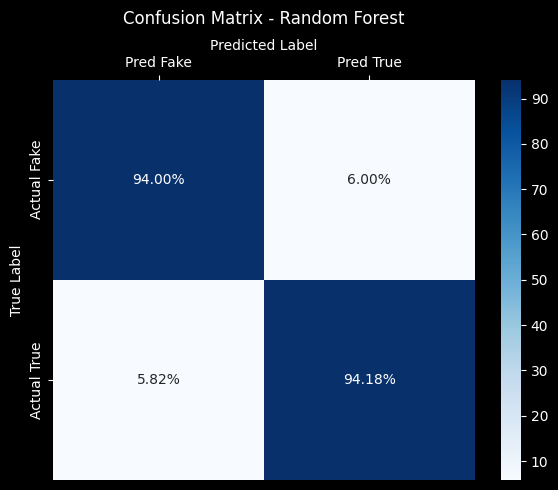


=== Logistic Regression Evaluation ===
Accuracy: 0.9147
F1 Score: 0.9119
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.92      7089
           1       0.95      0.88      0.91      7203

    accuracy                           0.91     14292
   macro avg       0.92      0.92      0.91     14292
weighted avg       0.92      0.91      0.91     14292

Confusion Matrix:
 [[6767  322]
 [ 897 6306]]
[INFO] Saved metrics to Logistic Regression_metrics.txt



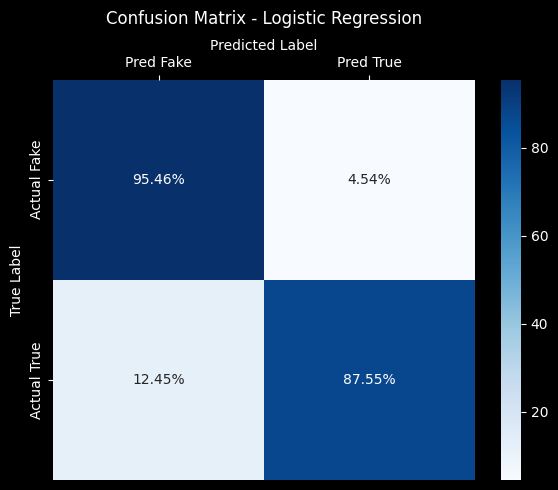


=== LightGBM Evaluation ===
Accuracy: 0.9036
F1 Score: 0.9055
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      7089
           1       0.89      0.92      0.91      7203

    accuracy                           0.90     14292
   macro avg       0.90      0.90      0.90     14292
weighted avg       0.90      0.90      0.90     14292

Confusion Matrix:
 [[6313  776]
 [ 602 6601]]
[INFO] Saved metrics to LightGBM_metrics.txt



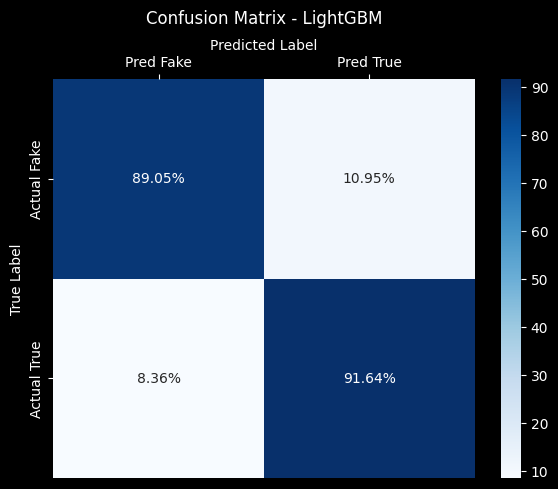

In [7]:
# === Random Forest ===
y_pred_rf = rf_model.predict(X_chi2)
evaluate_model("Random Forest", y_true, y_pred_rf)

# === Logistic Regression ===
X_infogain_tensor = torch.tensor(X_infogain.todense(), dtype=torch.float32).to(device)
lr_probs = lr_model(X_infogain_tensor).detach().cpu().numpy()[:, 1]
y_pred_lr = (lr_probs >= 0.5).astype(int)
evaluate_model("Logistic Regression", y_true, y_pred_lr)

# === LightGBM ===
lgbm_probs = lgb_model.predict(X_glove_pca)

if issparse(lgbm_probs):
    lgbm_probs = lgbm_probs.toarray()  # type: ignore
elif isinstance(lgbm_probs, list) and all(issparse(m) for m in lgbm_probs):
    lgbm_probs = np.vstack([m.toarray() for m in lgbm_probs])  # type: ignore
else:
    lgbm_probs = np.asarray(lgbm_probs)

# Handle 2D probability arrays (binary classification: [prob_0, prob_1])
if lgbm_probs.ndim == 2 and lgbm_probs.shape[1] == 2:
    lgbm_probs = lgbm_probs[:, 1]

# Threshold to get binary prediction
y_pred_lgbm = (lgbm_probs >= 0.5).astype(int)

# Evaluate
evaluate_model("LightGBM", y_true, y_pred_lgbm)


## Loading and Generating Predictions of Models

In [8]:
test_labels = test_df["label"].to_numpy()

with open("models/rf_model.pkl", "rb") as f:
    rf_model = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr_model = torch.load("models/lr_model.pth", map_location=device, weights_only=False)
lr_model.eval()

lgb_model = lgb.Booster(model_file="models/lgbm_model.txt")

X_chi2 = features["chi2"]
X_infogain = features["infogain"]
X_glove_pca = features["glove_pca"]

rf_test_probs = rf_model.predict_proba(X_chi2)[:, 1]

X_infogain_tensor = torch.tensor(X_infogain.toarray(), dtype=torch.float32).to(device)
lr_test_probs = lr_model(X_infogain_tensor).detach().cpu().numpy()[:, 1]

lgbm_test_probs = lgb_model.predict(X_glove_pca)

# Ensure `lgbm_test_probs` is a 1D array by extracting the probabilities for the positive class (class 1)
if isinstance(lgbm_test_probs, np.ndarray) and len(lgbm_test_probs.shape) > 1:
    lgbm_test_probs = lgbm_test_probs[:, 1]


## Soft Voting

In [9]:
avg_test_probs = (rf_test_probs + lr_test_probs + lgbm_test_probs) / 3
soft_test_preds = (avg_test_probs >= 0.5).astype(int)


## Hard Voting

In [10]:
rf_test_classes = (np.array(rf_test_probs) >= 0.5).astype(int)
lr_test_classes = (np.array(lr_test_probs) >= 0.5).astype(int)
lgbm_test_classes = (np.array(lgbm_test_probs) >= 0.5).astype(int)

all_test_preds = np.vstack([rf_test_classes, lr_test_classes, lgbm_test_classes])
hard_test_preds, _ = mode(all_test_preds, axis=0)
hard_test_preds = np.squeeze(hard_test_preds)


## Evaluation Function

In [11]:
def evaluate(name, preds):
    """Evaluate the performance of an ensemble model."""

    print(f"\n=== {name} Ensemble Test Evaluation ===")
    acc = accuracy_score(test_labels, preds)
    f1 = f1_score(test_labels, preds)
    report = classification_report(test_labels, preds)
    matrix = confusion_matrix(test_labels, preds)
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:\n", report)
    print("Predictions:\n", preds)

    with open(f"evaluations/{name}_metrics.txt", "w") as f:
        f.write(f"Accuracy: {acc:.4f}\n")
        f.write(f"F1 Score: {f1:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(str(report))
        f.write("\nConfusion Matrix:\n")
        f.write(np.array2string(matrix))

    cm_percent = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis] * 100

    annot = np.array([[f"{val:.2f}%" for val in row] for row in cm_percent])

    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(
        cm_percent,
        annot=annot,
        fmt="",
        cmap="Blues",
        cbar=True,
        xticklabels=["Pred Fake", "Pred True"],
        yticklabels=["Actual Fake", "Actual True"],
    )
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    plt.title(f"Confusion Matrix {name} Ensemble", pad=40)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig(f"assets/confusion_matrix_{name}.png")
    plt.show()



=== Soft Voting Ensemble Test Evaluation ===
Accuracy: 0.9393
F1 Score: 0.9386
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      7089
           1       0.96      0.92      0.94      7203

    accuracy                           0.94     14292
   macro avg       0.94      0.94      0.94     14292
weighted avg       0.94      0.94      0.94     14292

Predictions:
 [1 1 1 ... 1 1 1]


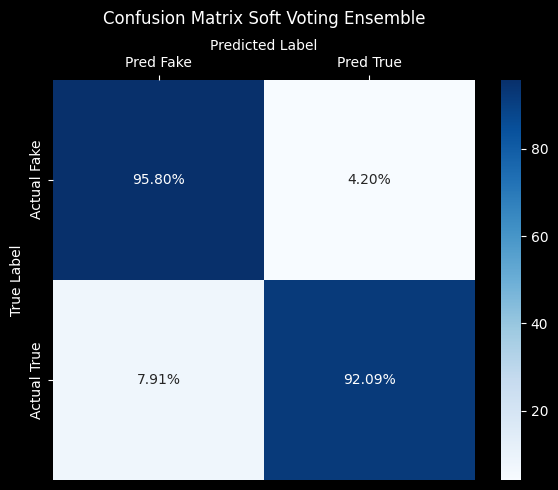


=== Hard Voting Ensemble Test Evaluation ===
Accuracy: 0.9437
F1 Score: 0.9441
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      7089
           1       0.95      0.94      0.94      7203

    accuracy                           0.94     14292
   macro avg       0.94      0.94      0.94     14292
weighted avg       0.94      0.94      0.94     14292

Predictions:
 [1 1 1 ... 1 1 1]


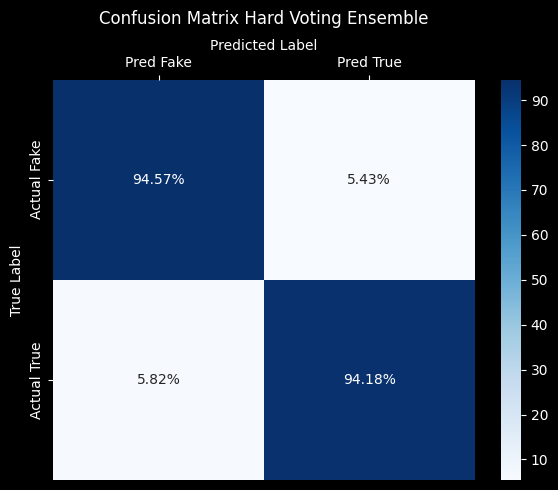

In [12]:
evaluate("Soft Voting", soft_test_preds)
evaluate("Hard Voting", hard_test_preds)

with open("predictions/soft_voting_test_preds.pkl", "wb") as f:
    pickle.dump(soft_test_preds, f)

with open("predictions/hard_voting_test_preds.pkl", "wb") as f:
    pickle.dump(hard_test_preds, f)
